In [1]:
import os
import json

import httpx
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from dotenv import load_dotenv

load_dotenv()

RESERVOIR_API_KEY = os.getenv("RESERVOIR_API_KEY")
RESERVOIR_API_URL = "https://api.reservoir.tools/owners/v2"

ALCHEMY_API_KEY = os.getenv("ALCHEMY_API_KEY")
ALCHEMY_API_URL = f"https://eth-mainnet.g.alchemy.com/nft/v3/{ALCHEMY_API_KEY}/getOwnersForContract"

bluechip_collections = tqdm(pd.read_csv("./data/bluechip_collections.csv").to_dict(orient="records"))

  0%|          | 0/105 [00:00<?, ?it/s]

In [2]:
def write_json(data, filename):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)
        

def read_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

In [ ]:
"""
    reservoir https://api.reservoir.tools/owners/v2 api는 이때까지 거래된 모든 owner를 가져오기 때문에 사용하기에는 무리가 있음
"""
for bluechip_collection in bluechip_collections:
    bluechip_collections.set_description(bluechip_collection["collectionId"])

    offset = 0
    owners = {"owners": []}
    
    while True:
        print(f"offset: {offset}, owner count: {len(owners['owners'])}")
        response = httpx.get(
            RESERVOIR_API_URL,
            params={
                "collection": bluechip_collection["collectionId"],
                "limit": 500,
                "offset": offset,
            },
            headers={"x-api-key": RESERVOIR_API_KEY},
        )
        
        response.raise_for_status()
        
        data = response.json()["owners"]
        owners["owners"].extend(data)
        
        if len(data) < 500:
            write_json(owners, f"./data/owners/{bluechip_collection['collectionId']}.json")
            break
        else:
            offset += 1


In [30]:
df = pd.DataFrame(read_json("./data/onwers_distributions/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d.json")["ownersDistribution"])
df

,tokenCount,ownerCount
0,1,4487
1,2,582
2,3,218
3,4,94
4,5,41
5,6,23
6,7,17
7,8,8
8,9,10
9,10,15


<Figure size 2000x2000 with 0 Axes>

<Axes: xlabel='tokenCount', ylabel='ownerCount'>

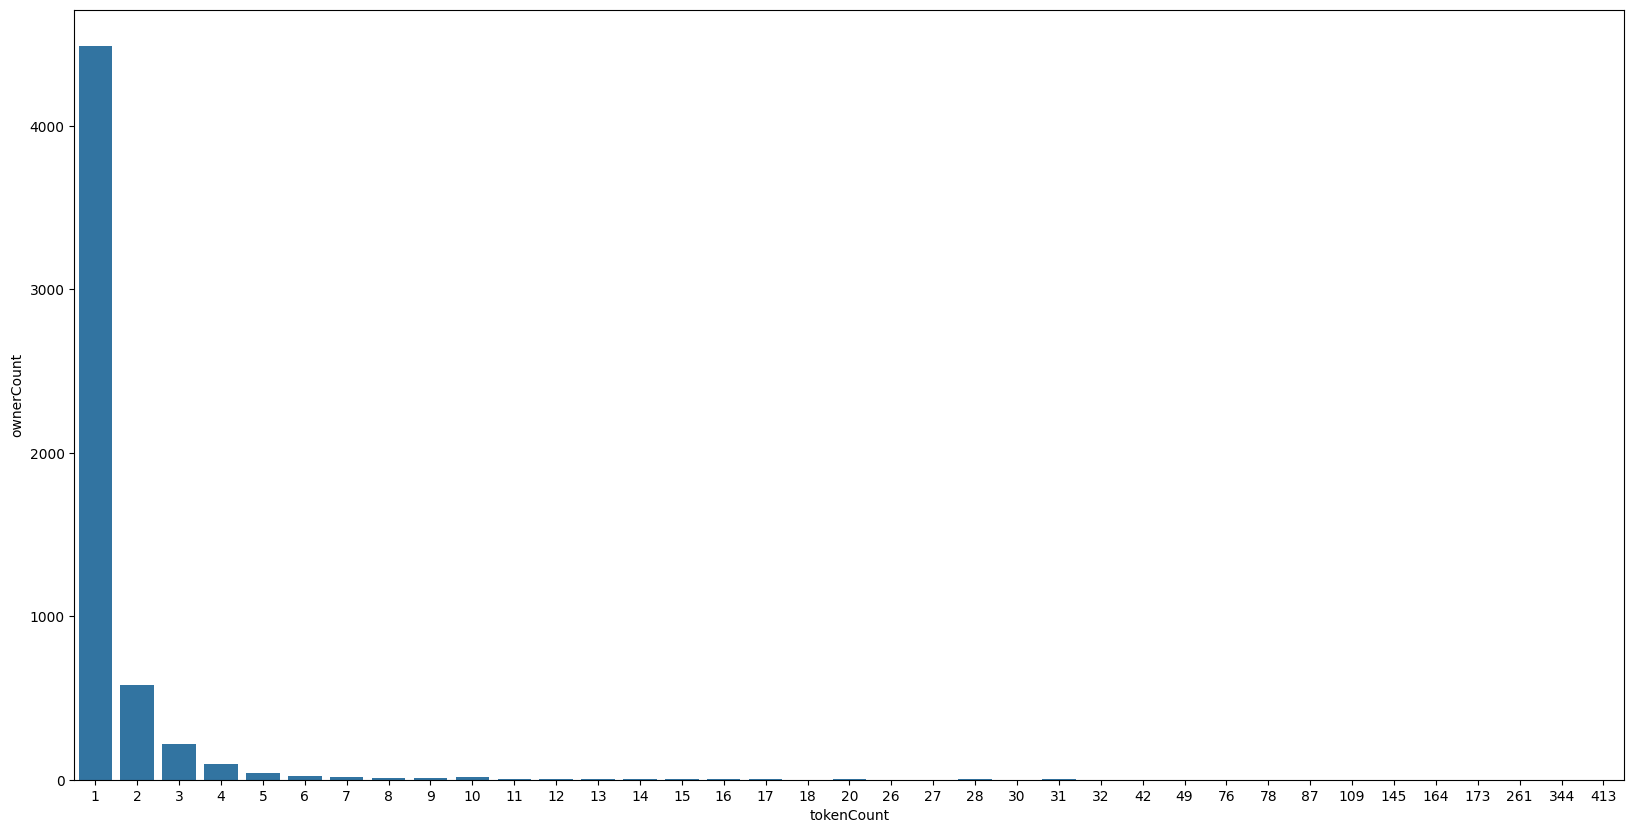

In [38]:
plt.figure(figsize=(20, 10))

sns.barplot(df, x="tokenCount", y="ownerCount")

In [42]:
df["ownerCount"].sum()

5546

In [44]:
alchemy_getowners_sample = read_json("./data/getOwnerForContract/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d.json")
alchemy_getowners_sample

{'owners': [{'ownerAddress': '0x000000000000000000000000000000000000dEaD',
   'tokenBalances': [{'tokenId': '4885', 'balance': '1'},
    {'tokenId': '8860', 'balance': '1'}]},
  {'ownerAddress': '0x0000000A1770e1Df35787B39a36A94FF4a4aaCD9',
   'tokenBalances': [{'tokenId': '2837', 'balance': '1'}]},
  {'ownerAddress': '0x001e3AB6C6E6DE3D602C9C43AE29E3e3d395AaE5',
   'tokenBalances': [{'tokenId': '9464', 'balance': '1'}]},
  {'ownerAddress': '0x001fd093d89b24f7DE35Bc47B6d01C750F398707',
   'tokenBalances': [{'tokenId': '8835', 'balance': '1'}]},
  {'ownerAddress': '0x0028109B8B6Ca54E7e1c372CfC2a68B7e477cd43',
   'tokenBalances': [{'tokenId': '1427', 'balance': '1'}]},
  {'ownerAddress': '0x002Cfa1f84874A394Fc06773Aa18Fa7d086a333B',
   'tokenBalances': [{'tokenId': '4143', 'balance': '1'}]},
  {'ownerAddress': '0x00584363400c0b874277eDD8cB16BC58b4b00aE2',
   'tokenBalances': [{'tokenId': '3754', 'balance': '1'},
    {'tokenId': '4652', 'balance': '1'}]},
  {'ownerAddress': '0x00625B93001

In [45]:
alchemy_getowners_sample = alchemy_getowners_sample["owners"]

owners = [owner["ownerAddress"] for owner in alchemy_getowners_sample]

print(len(set(owners)))

5542


In [51]:
for bluechip_collection in bluechip_collections:
    bluechip_collections.set_description(bluechip_collection["collectionId"])
    
    if os.path.exists(f"./data/getOwnerForContract/{bluechip_collection['collectionId']}.json"):
        continue
    
    response = httpx.get(
        ALCHEMY_API_URL,
        params={
            "contractAddress": bluechip_collection["collectionId"],
            "withTokenBalances": True
        }
    )
    
    response.raise_for_status()
    
    data = response.json()
    
    write_json(data, f"./data/getOwnerForContract/{bluechip_collection['collectionId']}.json")

In [3]:
owner_contracts = []

for bluechip_collection in bluechip_collections:
    onwer_contract = read_json(f"./data/getOwnerForContract/{bluechip_collection['collectionId']}.json")
    owner_contract = onwer_contract["owners"]
    
    for owner in owner_contract:
        owner_contracts.append({
            "collectionId": bluechip_collection["collectionId"],
            "ownerAddress": owner["ownerAddress"],
            "tokenCount": len(owner["tokenBalances"])
        })
        
owner_contracts = pd.DataFrame(owner_contracts)

100%|██████████| 105/105 [00:12<00:00,  8.09it/s]


In [54]:
owner_contracts

,collectionId,ownerAddress,tokenCount
0,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x000000000000000000000000000000000000dEaD,2
1,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x0000000A1770e1Df35787B39a36A94FF4a4aaCD9,1
2,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x001e3AB6C6E6DE3D602C9C43AE29E3e3d395AaE5,1
3,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x001fd093d89b24f7DE35Bc47B6d01C750F398707,1
4,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x0028109B8B6Ca54E7e1c372CfC2a68B7e477cd43,1
...,...,...,...
352166,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xfeBc550637A27D0C3d3C06C9b751D45D2301f1b2,1
352167,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xFEf1E137DA242a749ac64E7F6F90E5F09bd15f3b,4
352168,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xFF818b1595797267BDFce464b6C46a0468D51185,3
352169,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xfF8991b1FA6b84e141Bde964D442Ceae0348040E,1


In [11]:
df_bluechip_collections = pd.DataFrame(bluechip_collections)
del df_bluechip_collections["slug"], df_bluechip_collections["collectionRankingDateCount"], df_bluechip_collections["volume"]

df_cal = pd.merge(owner_contracts, df_bluechip_collections, on="collectionId", how="left")

df_cal

,collectionId,ownerAddress,tokenCount,floorprice
0,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x000000000000000000000000000000000000dEaD,2,28.014376
1,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x0000000A1770e1Df35787B39a36A94FF4a4aaCD9,1,28.014376
2,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x001e3AB6C6E6DE3D602C9C43AE29E3e3d395AaE5,1,28.014376
3,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x001fd093d89b24f7DE35Bc47B6d01C750F398707,1,28.014376
4,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x0028109B8B6Ca54E7e1c372CfC2a68B7e477cd43,1,28.014376
...,...,...,...,...
348536,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xfeBc550637A27D0C3d3C06C9b751D45D2301f1b2,1,0.589058
348537,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xFEf1E137DA242a749ac64E7F6F90E5F09bd15f3b,4,0.589058
348538,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xFF818b1595797267BDFce464b6C46a0468D51185,3,0.589058
348539,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xfF8991b1FA6b84e141Bde964D442Ceae0348040E,1,0.589058


In [12]:
df_cal["estimated_price"] = df_cal["tokenCount"] * df_cal["floorprice"]
df_cal

,collectionId,ownerAddress,tokenCount,floorprice,estimated_price
0,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x000000000000000000000000000000000000dEaD,2,28.014376,56.028752
1,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x0000000A1770e1Df35787B39a36A94FF4a4aaCD9,1,28.014376,28.014376
2,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x001e3AB6C6E6DE3D602C9C43AE29E3e3d395AaE5,1,28.014376,28.014376
3,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x001fd093d89b24f7DE35Bc47B6d01C750F398707,1,28.014376,28.014376
4,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0x0028109B8B6Ca54E7e1c372CfC2a68B7e477cd43,1,28.014376,28.014376
...,...,...,...,...,...
348536,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xfeBc550637A27D0C3d3C06C9b751D45D2301f1b2,1,0.589058,0.589058
348537,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xFEf1E137DA242a749ac64E7F6F90E5F09bd15f3b,4,0.589058,2.356233
348538,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xFF818b1595797267BDFce464b6C46a0468D51185,3,0.589058,1.767175
348539,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xfF8991b1FA6b84e141Bde964D442Ceae0348040E,1,0.589058,0.589058


In [13]:
df_cal.to_csv("./data/owner_contracts_with_estimated_price.csv", index=False)

In [6]:
df_cal.loc[df_cal["estimated_price"] == 0]

,collectionId,ownerAddress,tokenCount,floorprice,estimated_price


In [14]:
df_cal = df_cal.groupby("ownerAddress").sum("estimated_price").sort_values("estimated_price", ascending=False).reset_index()
df_cal

,ownerAddress,tokenCount,floorprice,estimated_price
0,0x0000000000000000000000000000000000000000,79064,71.441652,118489.473129
1,0x000000000000000000000000000000000000dEaD,51975,47.554784,31110.329586
2,0x29469395eAf6f95920E59F858042f0e28D98a20B,4195,110.588630,18861.488602
3,0x67e1eCFA9232E27EAf3133B968A33A9a0dCa9e16,3315,10.787018,16865.841444
4,0x2F53e033C55eB6C87CEa259123C0a68Ca3578426,7520,2.058580,15480.523527
...,...,...,...,...
210685,0x0dB20B41C749ed736044A606DE91d68376B174fb,1,0.000255,0.000255
210686,0x19bBc922147081459fd63aF530beCcC8402a17B1,1,0.000255,0.000255
210687,0x094F64b8b2d45ABc32E545a27Ae2b4Bf01d4e7a7,1,0.000255,0.000255
210688,0x136db729EBdF358B7A9E29cAbA768504Cd5c6dc8,1,0.000255,0.000255


In [16]:
df_cal.to_csv("./data/owner_contracts_with_estimated_price_sum.csv", index=False)

In [10]:
df_cal.loc[df_cal["estimated_price"] > 36.54635499]

,ownerAddress,tokenCount,floorprice,estimated_price
0,0x0000000000000000000000000000000000000000,79064,71.441652,118489.473129
1,0x000000000000000000000000000000000000dEaD,51975,47.554784,31110.329586
2,0x29469395eAf6f95920E59F858042f0e28D98a20B,4195,110.588630,18861.488602
3,0x67e1eCFA9232E27EAf3133B968A33A9a0dCa9e16,3315,10.787018,16865.841444
4,0x2F53e033C55eB6C87CEa259123C0a68Ca3578426,7520,2.058580,15480.523527
...,...,...,...,...
5067,0x33A195fB55671fC2205764955393108645ebBa38,10,33.624331,36.561162
5068,0xD78cE583e4A17b0E889797C7193846937b627F5C,19,34.490030,36.554466
5069,0x4241B875D35D9990d29a8F8DCCAf88Bad8D46c24,10,34.496162,36.554141
5070,0x18aD7A4D1a3a5701EF9B462D10aee7AC9D62571e,15,12.736434,36.551395


In [17]:
df_whales = df_cal.loc[df_cal["estimated_price"] > 36.54635499]
df_whales

,ownerAddress,tokenCount,floorprice,estimated_price
0,0x0000000000000000000000000000000000000000,79064,71.441652,118489.473129
1,0x000000000000000000000000000000000000dEaD,51975,47.554784,31110.329586
2,0x29469395eAf6f95920E59F858042f0e28D98a20B,4195,110.588630,18861.488602
3,0x67e1eCFA9232E27EAf3133B968A33A9a0dCa9e16,3315,10.787018,16865.841444
4,0x2F53e033C55eB6C87CEa259123C0a68Ca3578426,7520,2.058580,15480.523527
...,...,...,...,...
5067,0x33A195fB55671fC2205764955393108645ebBa38,10,33.624331,36.561162
5068,0xD78cE583e4A17b0E889797C7193846937b627F5C,19,34.490030,36.554466
5069,0x4241B875D35D9990d29a8F8DCCAf88Bad8D46c24,10,34.496162,36.554141
5070,0x18aD7A4D1a3a5701EF9B462D10aee7AC9D62571e,15,12.736434,36.551395


In [18]:
df_whales.drop([0], axis=0, inplace=True)
df_whales

/var/folders/k3/2w4zylcs0l12r34ky2dtqg5h0000gn/T/ipykernel_84485/1731947404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_whales.drop([0], axis=0, inplace=True)


,ownerAddress,tokenCount,floorprice,estimated_price
1,0x000000000000000000000000000000000000dEaD,51975,47.554784,31110.329586
2,0x29469395eAf6f95920E59F858042f0e28D98a20B,4195,110.588630,18861.488602
3,0x67e1eCFA9232E27EAf3133B968A33A9a0dCa9e16,3315,10.787018,16865.841444
4,0x2F53e033C55eB6C87CEa259123C0a68Ca3578426,7520,2.058580,15480.523527
5,0x3eb879cc9a0Ef4C6f1d870A40ae187768c278Da2,5612,67.563512,13353.793545
...,...,...,...,...
5067,0x33A195fB55671fC2205764955393108645ebBa38,10,33.624331,36.561162
5068,0xD78cE583e4A17b0E889797C7193846937b627F5C,19,34.490030,36.554466
5069,0x4241B875D35D9990d29a8F8DCCAf88Bad8D46c24,10,34.496162,36.554141
5070,0x18aD7A4D1a3a5701EF9B462D10aee7AC9D62571e,15,12.736434,36.551395


In [19]:
df_whales.drop(["floorprice"], axis=1, inplace=True)
df_whales

/var/folders/k3/2w4zylcs0l12r34ky2dtqg5h0000gn/T/ipykernel_84485/4156345789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_whales.drop(["floorprice"], axis=1, inplace=True)


,ownerAddress,tokenCount,estimated_price
1,0x000000000000000000000000000000000000dEaD,51975,31110.329586
2,0x29469395eAf6f95920E59F858042f0e28D98a20B,4195,18861.488602
3,0x67e1eCFA9232E27EAf3133B968A33A9a0dCa9e16,3315,16865.841444
4,0x2F53e033C55eB6C87CEa259123C0a68Ca3578426,7520,15480.523527
5,0x3eb879cc9a0Ef4C6f1d870A40ae187768c278Da2,5612,13353.793545
...,...,...,...
5067,0x33A195fB55671fC2205764955393108645ebBa38,10,36.561162
5068,0xD78cE583e4A17b0E889797C7193846937b627F5C,19,36.554466
5069,0x4241B875D35D9990d29a8F8DCCAf88Bad8D46c24,10,36.554141
5070,0x18aD7A4D1a3a5701EF9B462D10aee7AC9D62571e,15,36.551395


In [20]:
df_whales.to_csv("./data/whales.csv", index=False)